Assignment 2

Q1

Q2

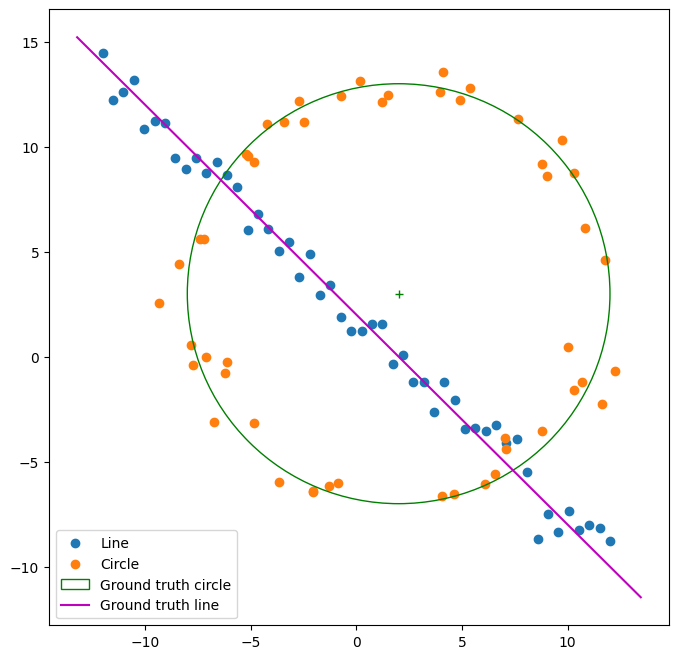

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import tikzplotlib

# np.random.seed(0)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line))  # All points

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()


plt.show()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.3242808113316396e-08
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.4904107926227328e-08
            Iterations: 6
            Function evaluations: 26
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2430329096253e-08
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.84224820115823e-07
            Iterations: 17
            Function evaluations: 84
            Gradient evaluations: 17
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.771948377529557e-08
            Iterations: 10
            Func

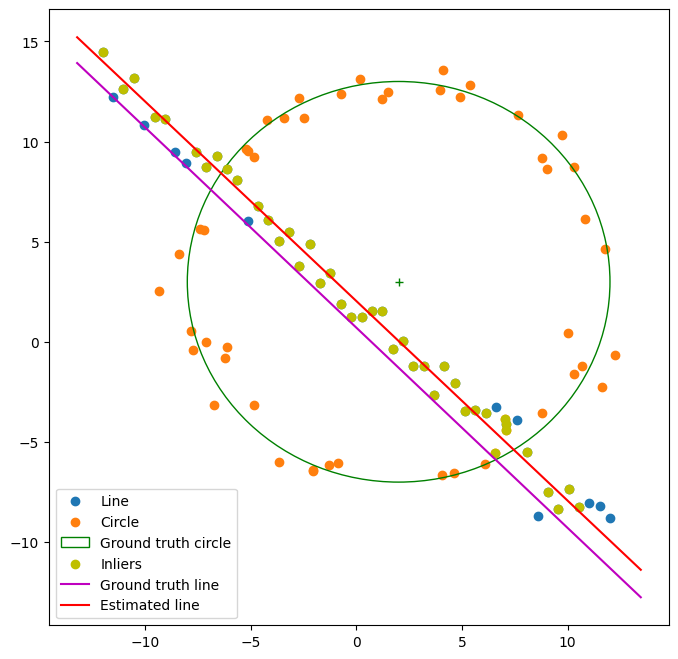

In [2]:
import math
N = X.shape[0]
X_ = X

def line_equation_from_points(x1, y1, x2, y2):
    
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d


def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))


def g(x):
    return x[0]**2 + x[1]**2 - 1


cons = ({'type': 'eq', 'fun': g})


def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

N = X.shape[0]
t = 1.0              # Threshold for inliers
d = 0.4 * N          # Minimum inliers required
s = 2                # Number of points for model estimation
max_iterations = 50

best_model_line = []
best_error = np.inf
best_sample_line = []
best_inliers_line = []
res_only_with_sample = []

for i in range(max_iterations):
        
        sample = np.random.choice(N, s, replace=False)
        x0 = np.array([1, 1, 0])
        res = minimize(fun=line_tls, args=sample, x0=x0, tol= 1e-6, constraints=cons, options={'disp': True})
    
        inliers = consensus_line(X_, res.x, t)
        n_inliers = np.sum(inliers)

        if n_inliers > d:
            x0 = res.x
            res = minimize(fun = line_tls, args = inliers, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
            if res.fun < best_error:
                best_model_line = res.x
                best_error = res.fun
                best_sample_line = sample
                best_inliers_line = inliers
                res_only_with_sample = x0

            
        
        

# Print the best model
print('Best line model:', best_model_line)

a = best_model_line[0]
b = best_model_line[1]
d0 = best_model_line[2]

fig,ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(X_line[:,0],X_line[:,1],label='Line')
ax.scatter(X_circ[:,0],X_circ[:,1],label='Circle')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

ax.scatter(X[best_inliers_line,0],X[best_inliers_line,1], color='y', label='Inliers')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')


# Plot the best model


y_est = (-a/b)*x_ + (d0/b)
ax.plot(x_, y_est, color='red', label='Estimated line')

#ax.scatter(X[best_sample_line, 0], X[best_sample_line, 1], color='k', label='Best sample')

plt.legend()
plt.show()


In [3]:
remaining = X

if best_inliers_line is not None:
    remaining = X[best_inliers_line, :]

def circle_consensus(data, x,t):
   
    x0,y0,r = x[0],x[1],x[2]
    distances = np.sqrt((data[:, 0] - x0)**2 + (data[:, 1] - y0)**2)
    
    return np.abs(distances - r) < t

def circle_tls(x, indices, remaining):
    x0,y0, r = x[0], x[1], x[2]
    error = np.sqrt((remaining[indices, 0] - x0)**2 + (remaining[indices, 1] - y0)**2 )
    
    return np.sum(np.abs(error-r))

t2 = 0.5

cons_circle={'type': 'ineq', 'fun': lambda x: x[2] - t2}

n2 = X_circ.shape[0]
d2 = 0.4 * n2
s2 = 3
max_iterations = 50

best_model_circle = []
best_error_circle = np.inf
best_sample_circle = []
best_inliers_circle = []
res_only_with_sample_circle = []

for i in range(max_iterations):

    sample2 = np.random.choice(n2, s2, replace=False)
    x0_circle = np.array([1, 1, 1])
    res2 = minimize(fun=circle_tls, args=(sample2, X_circ), x0=x0_circle, tol= 1e-6, constraints=cons_circle, options={'disp': True})
    inliers2 = circle_consensus(X_circ, res2.x, t2)
    n_inliers2 = np.sum(inliers2)

    if n_inliers2 > d2:
        x0_circle = res2.x
        res2 = minimize(fun = circle_tls, args = (inliers2, X_circ), x0 = x0_circle, tol= 1e-6, constraints=cons_circle, options={'disp': True})
        if res2.fun < best_error_circle:
            best_model_circle = res2.x
            best_error_circle = res2.fun
            best_sample_circle = sample2
            best_inliers_circle = inliers2
            res_only_with_sample_circle = x0_circle

# Print the best model

print('Best circle model:', best_model_circle)

            
            
            
            
           


Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.408174174689975e-07
            Iterations: 26
            Function evaluations: 140
            Gradient evaluations: 26
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3269789117819073e-07
            Iterations: 27
            Function evaluations: 144
            Gradient evaluations: 27
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8.519168570586544e-06
            Iterations: 48
            Function evaluations: 234
            Gradient evaluations: 48
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.21040721024724e-07
            Iterations: 28
            Function evaluations: 147
            Gradient evaluations: 28
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.97927418988103
            Iterations: 17
          

In [4]:
#print the best model with seperate features

x0_best_circle = best_model_circle[0]
y0_best_circle = best_model_circle[1]
r_best_circle = best_model_circle[2]

#print them

print('x0_best_circle:', x0_best_circle)
print('y0_best_circle:', y0_best_circle)
print('r_best_circle:', r_best_circle)

x0_best_circle: 2.120798483811778
y0_best_circle: 3.611071887440027
r_best_circle: 9.716229295019087


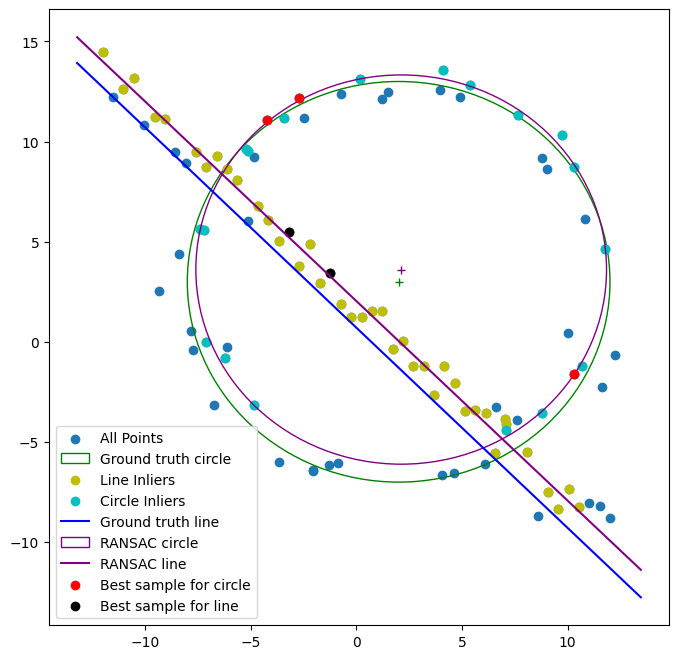

In [20]:
fig,ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(X[:,0],X[:,1],label='All Points')

circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')


ax.scatter(X[best_inliers_line,0],X[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(X_circ[best_inliers_circle,0],X_circ[best_inliers_circle,1], color='c', label='Circle Inliers')


x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
ax.plot(x_, y_, color='b', label='Ground truth line')

circle_est = plt.Circle((x0_best_circle, y0_best_circle), r_best_circle, color='purple', fill=False, label='RANSAC circle')
ax.add_patch(circle_est)
ax.plot(x0_best_circle, y0_best_circle, '+', color='purple')

y_est = (-a/b)*x_ + (d0/b)
ax.plot(x_, y_est, color='purple', label='RANSAC line')

ax.scatter(X_circ[best_sample_circle, 0], X_circ[best_sample_circle, 1], color='r', label='Best sample for circle')
#plot best sample for line in red
ax.scatter(X[best_sample_line, 0], X[best_sample_line, 1], color='k', label='Best sample for line')


plt.legend()
plt.show()


Q3

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

corners = []

def click_event(event, x, y, flags, params):
    if event == cv.EVENT_LBUTTONDOWN:
        corners.append([x, y])
        cv.circle(img, (x, y), 5, (0, 0, 255), -1)
        cv.imshow('image', img)
        
        if len(corners) == 4:
            cv.destroyAllWindows()

img = cv.imread('building.png')
cv.imshow('image', img)
cv.setMouseCallback('image', click_event)

cv.waitKey(0)

print(corners)

[[43, 67], [45, 121], [109, 122], [108, 71]]


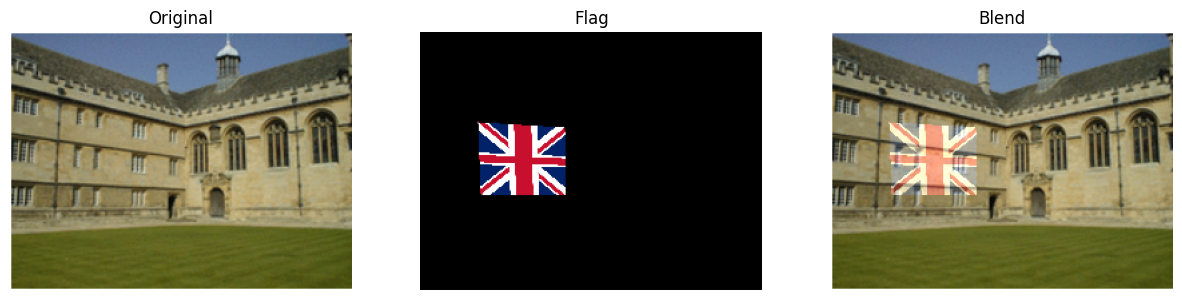

In [12]:
flag = cv.imread('uk_flag.png')
img2 = cv.imread('building.png')

rows, cols, ch = flag.shape
pts1 = np.float32(corners)
pts2 = np.float32([[0, 0], [cols, 0], [cols, rows], [0, rows]])

h = cv.findHomography(pts2, pts1)[0]
warped_flag = cv.warpPerspective(flag, h, (img.shape[1], img.shape[0]))
result = cv.addWeighted(img2, 1, warped_flag, 0.4, 0, dst=img)

warped_flag = cv.cvtColor(warped_flag, cv.COLOR_BGR2RGB)
result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)

fig,ax = plt.subplots(1, 3, figsize=(15, 8))


ax[0].imshow(img2),ax[0].set_title('Original'),ax[0].axis('off')
ax[1].imshow(warped_flag),ax[1].set_title('Flag'),ax[1].axis('off')
ax[2].imshow(result),ax[2].set_title('Blend'),ax[2].axis('off')

plt.show()

Q4

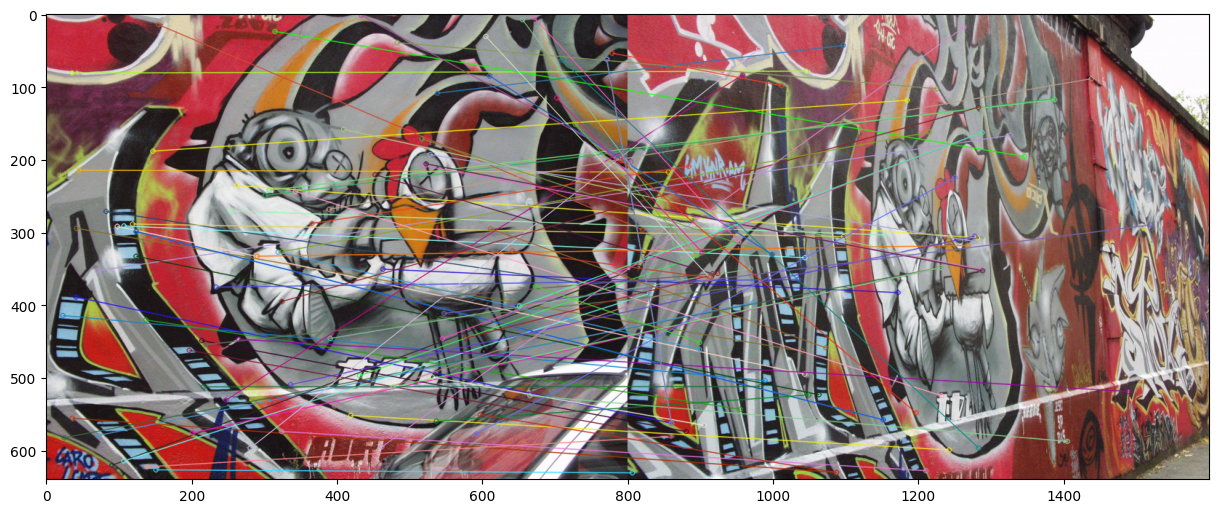

In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img1 = cv.imread('img1.ppm')
img5 = cv.imread('img5.ppm')

sift = cv.SIFT_create()

key_points1, descriptor1 = sift.detectAndCompute(img1,None)
key_points5, descriptor5 = sift.detectAndCompute(img5,None)

bf = cv.BFMatcher()

matches = bf.knnMatch(descriptor1,descriptor5, k=2)

good_matches = []

for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append([m])

img = cv.drawMatchesKnn(img1, key_points1, img5, key_points5, good_matches, None, flags=2)


img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

plt.figure(figsize=(15, 8))
plt.imshow(img)
plt.show()

